<a href="https://colab.research.google.com/github/ziatdinovmax/gpax/blob/main/examples/heteroskedasticGP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heteroskedastic Gaussian process in a fully Bayesian mode

This notebook demonstrates an application of the heteroskedastic Gaussian process class in GPax package to a toy 1D problem.

*Prepared by Maxim Ziatdinov (2023)*

In the standard Gaussian process regression models, the observation noise is assumed to be i.i.d. (independently and identically distributed) and Gaussian with a constant variance. This is called homoskedastic noise. However, in many real-world scenarios, the variance of the noise is not constant across the input space. Instead, it might change depending on the location in the input space. When the variance of the noise changes in this way, it's termed "heteroskedastic."

A heteroskedastic GP allows for non-constant noise variances. The GPax implementation for the heteroskedastic GP utilizes two Gaussian processes. One is for the main regression task (the signal) while the other is dedicated to modeling the variance of the noise (capturing heteroskedasticity). Both the main GP and the noise GP can have their own separate kernel and prior mean functions.

In this tutorial, we will explore how to use GPax for modeling heteroskedastic noise on a simple 1D example.

Install GPax:

In [ ]:
!pip install -q git+https://github.com/ziatdinovmax/gpax

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.3/360.3 kB 9.7 MB/s eta 0:00:00


Make neccessary imports and set up the computational environment to use 64-bit precision:

In [ ]:
import gpax

import numpy as np
import matplotlib.pyplot as plt


gpax.utils.enable_x64()

We will demonstrate the heteroskedastic GP on a synthetic dataset with non-constant noise. First, we will generate and plot the dataset

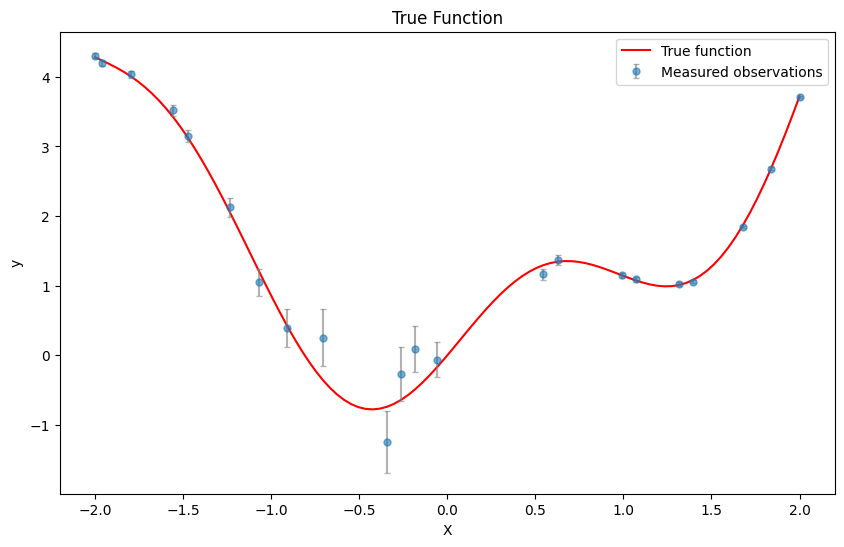

In [ ]:
# Define the base function
def f(x):
    return np.sin(3*x) + x**2

# Create the dense data ("true function")
np.random.seed(42)
X = np.linspace(-2, 2, 100)
y_true = f(X)

# Generate noise for each data point
noise_std = 0.1 / (0.2 + (X+0.5)**2)

# Include first and last indices, and randomly sample 20 points in between
indices = np.sort(np.concatenate([
    [0],
    np.random.choice(np.arange(1, X.shape[0]-1), 20, replace=False),
    [X.shape[0]-1]
]))

# Get observations in those points
X_measured = X[indices]
y_measured = y_true[indices] + np.random.randn(indices.shape[0]) * noise_std[indices]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(X, y_true, 'r', label='True function')
plt.errorbar(X_measured, y_measured, yerr=noise_std[indices], fmt='o',
             markersize=5, ecolor='gray', capsize=2, label='Measured observations', alpha=0.6)
plt.legend()
plt.title('True Function')
plt.xlabel('X')
plt.ylabel('y')
plt.show()

Let's set up and train a heteroskedastic GP model on the "measured" data

In [ ]:
key1, key2 = gpax.utils.get_keys(0)

model = gpax.VarNoiseGP(1, 'RBF', noise_kernel="Matern")

model.fit(key1, X_measured, y_measured, num_warmup=2000, num_samples=2000)

sample: 100%|██████████| 4000/4000 [02:14<00:00, 29.84it/s, 63 steps of size 9.98e-03. acc. prob=0.70]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
     k_length[0]      0.81      0.11      0.82      0.59      0.96    428.38      1.00
  k_noise_length      1.22      0.33      1.22      0.69      1.72     67.06      1.06
   k_noise_scale     12.12      7.43     10.64      2.71     20.54    574.65      1.00
         k_scale      8.29      4.94      7.31      2.35     14.24    637.77      1.00



Now, we will use the trained model to make predictions on the entire data range. We will also retrieve the variance of the data points from the model.

In [ ]:
y_pred, y_sampled = model.predict(key2, X)

data_variance = model.get_data_var_samples()

Finally, let's visualize the predictions of our GP model alongside the true function and the noisy measurements. We will also plot the inferred noise level and compare it with the actual noise

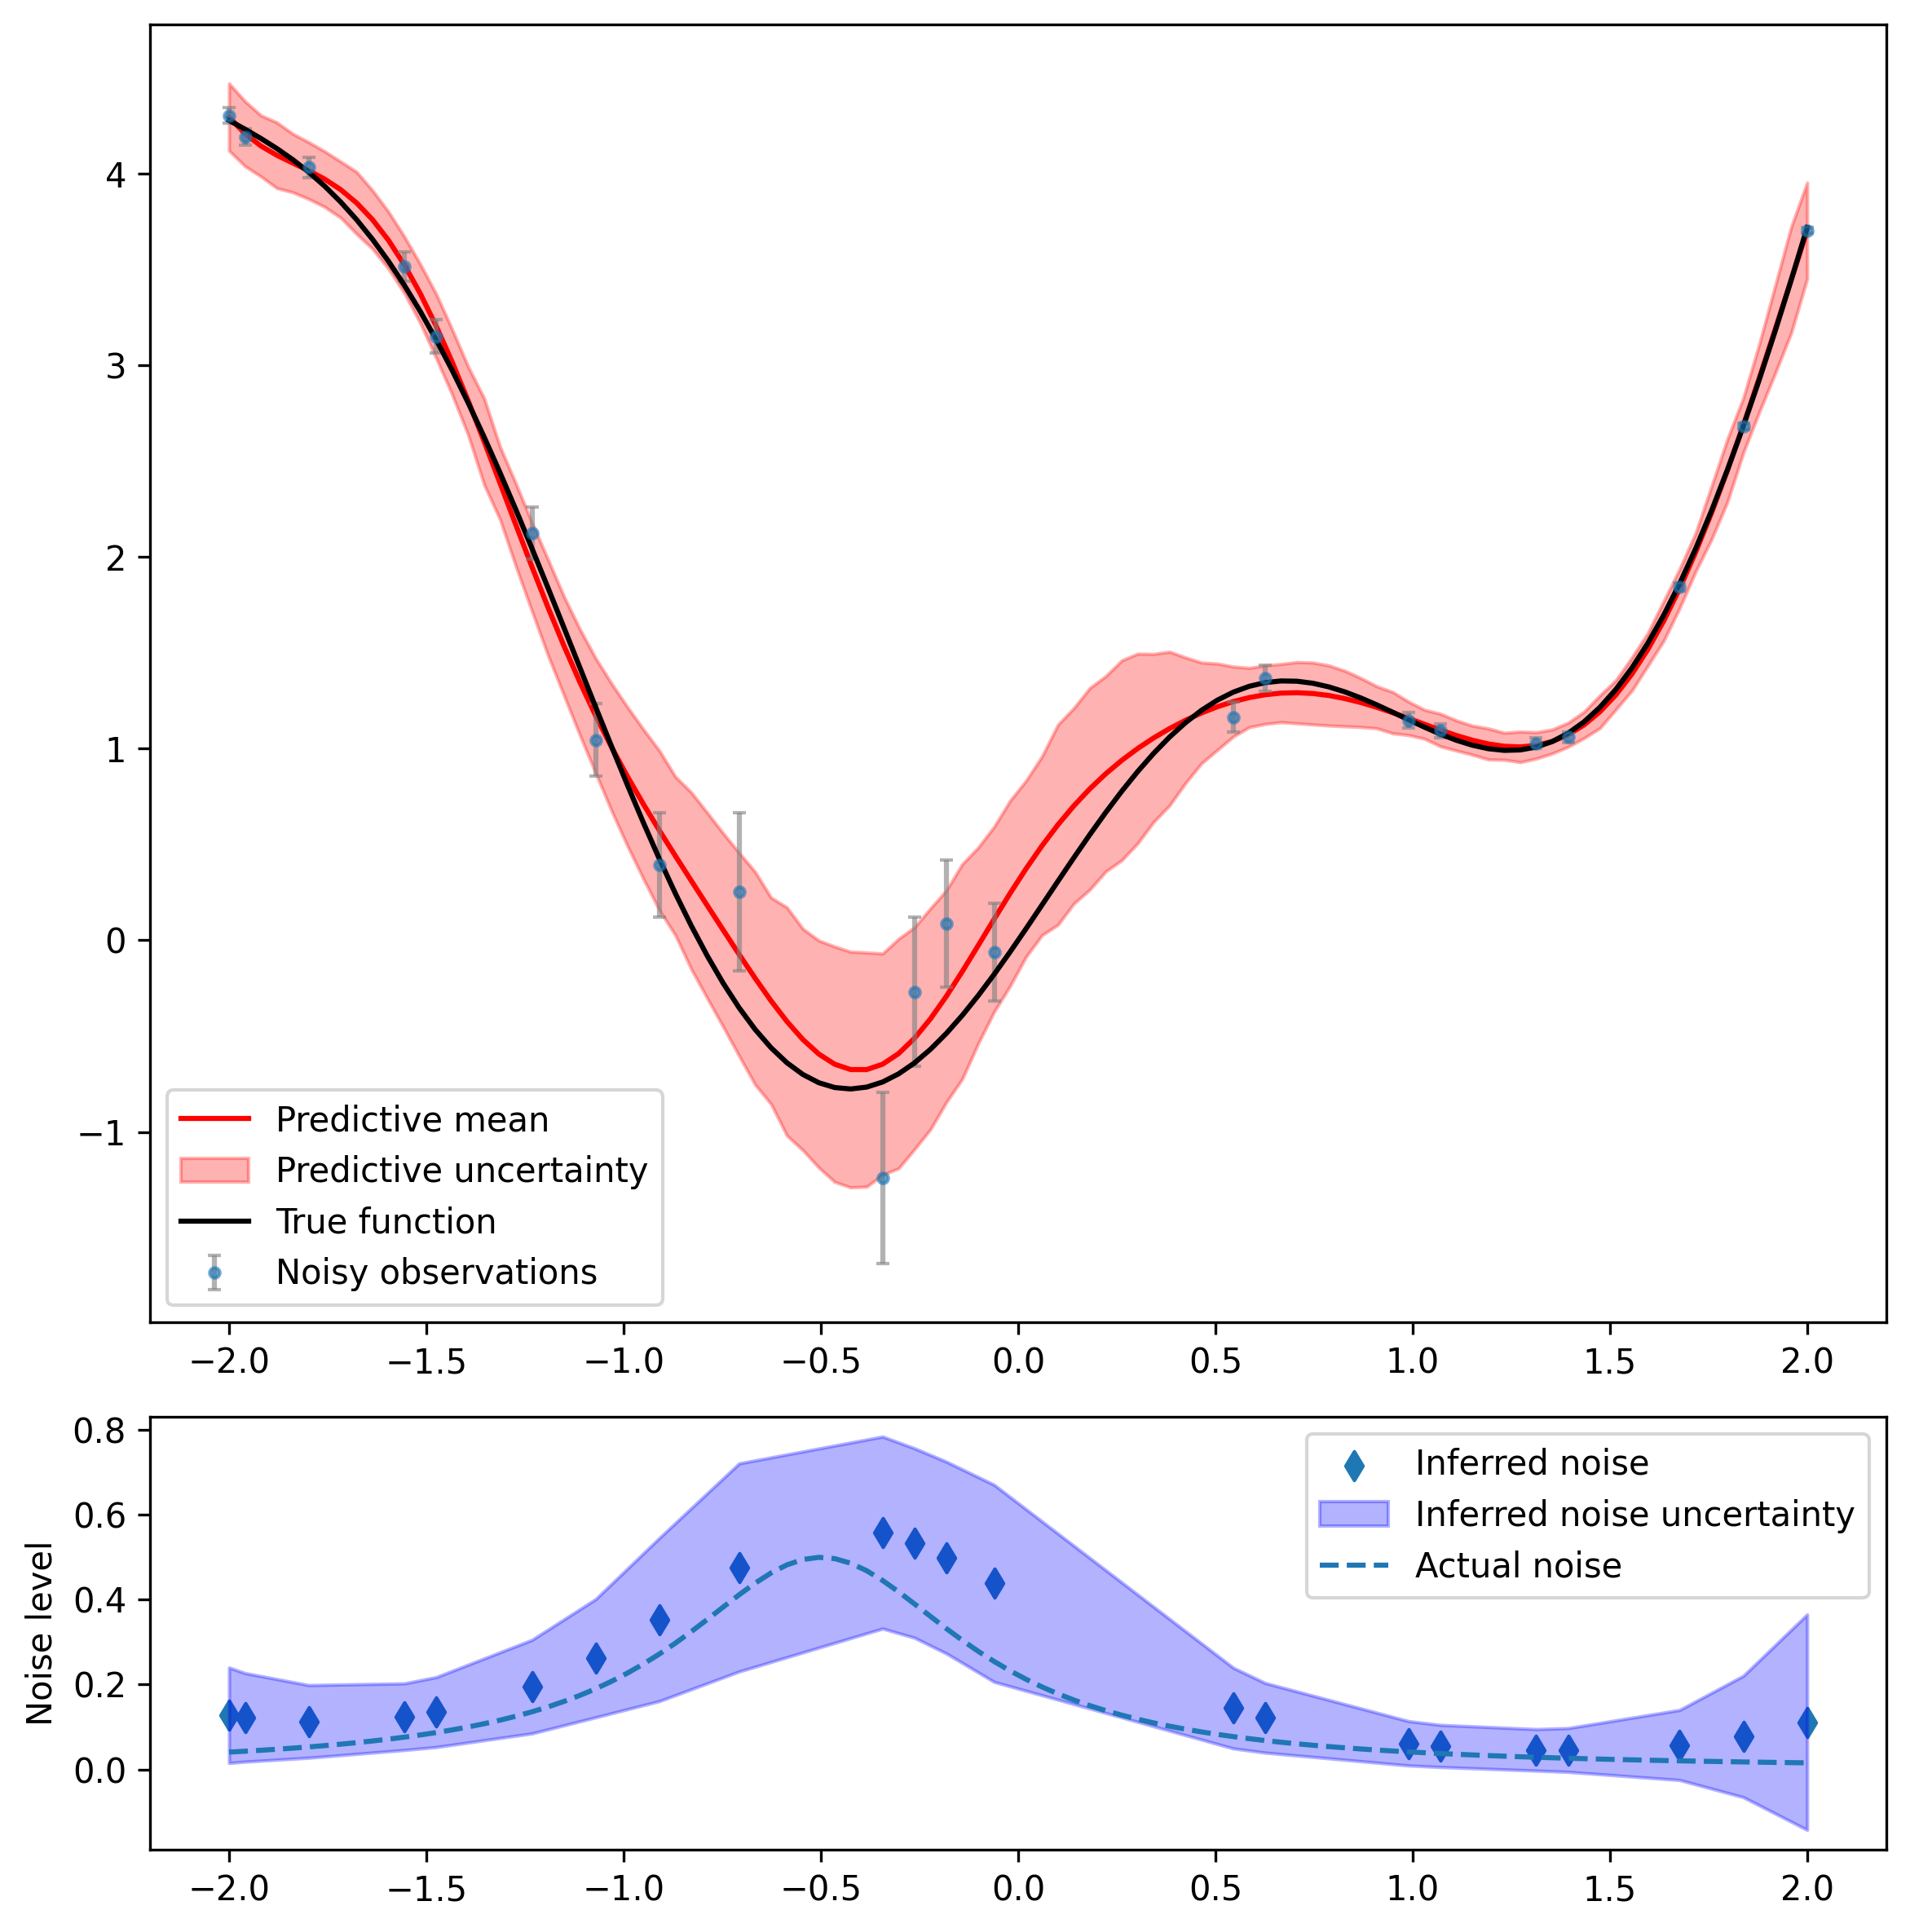

In [ ]:
lower_b = y_pred - y_sampled.std(axis=(0,1))
upper_b = y_pred + y_sampled.std(axis=(0,1))

noise_inferred = np.sqrt(data_variance)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), dpi=300, gridspec_kw={'height_ratios': [3, 1]})

# Main plot
ax1.plot(X, y_pred, c='r', label='Predictive mean')
ax1.fill_between(X, lower_b, upper_b, color='r', alpha=0.3, label="Predictive uncertainty")
ax1.errorbar(X_measured, y_measured, yerr=noise_std[indices], fmt='o', markersize=3, ecolor='gray', capsize=2, label='Noisy observations', alpha=0.6)
ax1.plot(X, y_true, 'k', label='True function')
ax1.legend(loc='best')

# Noise comparison subplot
plt.scatter(X_measured, noise_inferred.mean(0), marker='d', label='Inferred noise')
plt.fill_between(X_measured, noise_inferred.mean(0) - noise_inferred.std(0), noise_inferred.mean(0) + noise_inferred.std(0),
                 color='blue', alpha=0.3, label="Inferred noise uncertainty")
ax2.plot(X, noise_std, '--', label="Actual noise")
ax2.legend(loc='best')
ax2.set_ylabel("Noise level")

plt.tight_layout()
plt.show()
